In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import fastai; fastai.__version__

'2.7.13'

In [ ]:
!pip list

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import*

In [ ]:
#Create a meta file for nii files


files = []

# For Segmentation files
for dirname, _, filenames in os.walk(r'D:\Liver\Datasets\Segmentation'):
    for filename in filenames:
        files.append((dirname, filename))

# For Volume files
for dirname, _, filenames in os.walk(r'D:\Liver\Datasets\Volume'):
    for filename in filenames:
        files.append((dirname, filename))

df=pd.DataFrame(files, columns =['dir_name', 'file_name'])
df.sort_values(by=['file_name'], ascending=True)



,dir_name,file_name


In [ ]:
df["mask_dir"]=''
df["mask_file"]=''
for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    df.loc[df["file_name"]==ct, 'mask_file']=mask
    df.loc[df["file_name"]==ct, "mask_dir"]="D:\Liver\Datasets\Segmentation"

In [ ]:
df = df[df.mask_file !=''].sort_values(by=['file_name']).reset_index(drop=True)

In [ ]:
df

,dir_name,file_name,mask_dir,mask_file


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

def visualize_nii_file(nii_file_path):
    try:
        # Load the NII file
        nii_image = nib.load(nii_file_path)

        # Get the NII data as a NumPy array
        nii_data = nii_image.get_fdata()

        # Display the slices of the NII file with 6 images in a single row
        num_slices = nii_data.shape[-1]
        num_rows = (num_slices + 5) // 6  # Calculate the number of rows needed

        plt.figure(figsize=(16, 3 * num_rows))  # Adjust the figure size

        for i in range(54,55):
            plt.subplot(num_rows, 6, i + 1)
            plt.imshow(nii_data[ :,i,:], cmap='gray')
            plt.title(f"Slice {i + 1}")
            plt.axis('off')

        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
nii_file_path = "D:\Liver\Datasets\Volume/volume-0.nii"
visualize_nii_file(nii_file_path)

An error occurred: No such file or no access: 'D:\Liver\Datasets\Volume/volume-0.nii'


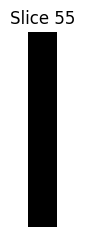

In [ ]:
mask_sample = "D:\Liver\Datasets\Segmentation/segmentation-0.nii"
visualize_nii_file(mask_sample)

In [ ]:
def read_nii(file):
    ct = nib.load(file)
    out = ct.get_fdata()
    out = np.rot90(np.array(out))
    return out

In [ ]:
sample = 0
sample_ct = read_nii(df.loc[sample,'dir_name']+"/"+df.loc[sample,'file_name'])
sample_mask = read_nii(df.loc[sample,'mask_dir']+"/"+df.loc[sample,'mask_file'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


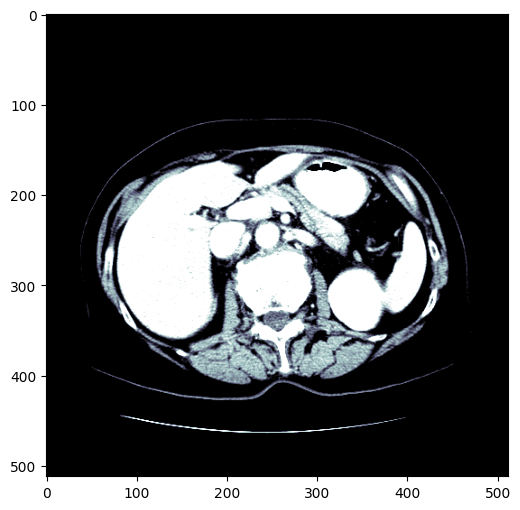

In [ ]:
# from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)
@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l-w//2
    px_max = l+w//2
    px[px<px_min]=px_min
    px[px>px_max]=px_max
    return (px-px_min)/(px_max-px_min)
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [ ]:
def plot_sample(arr_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(20,16), dpi=100)
    plt.subplot(1,4,1)
    plt.imshow(arr_list[0],cmap="bone")
    plt.title("original_image")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(tensor(arr_list[0].astype(np.float32)).windowed(*dicom_windows.liver),cmap='bone');
    plt.title("windowed_image")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(arr_list[1],alpha=0.5, cmap=color_map)
    plt.title("mask")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(arr_list[0],cmap="bone")
    plt.imshow(arr_list[1],alpha=0.5, cmap=color_map)
    plt.title("Liver_with_mask")
    plt.axis("off")


    plt.show()

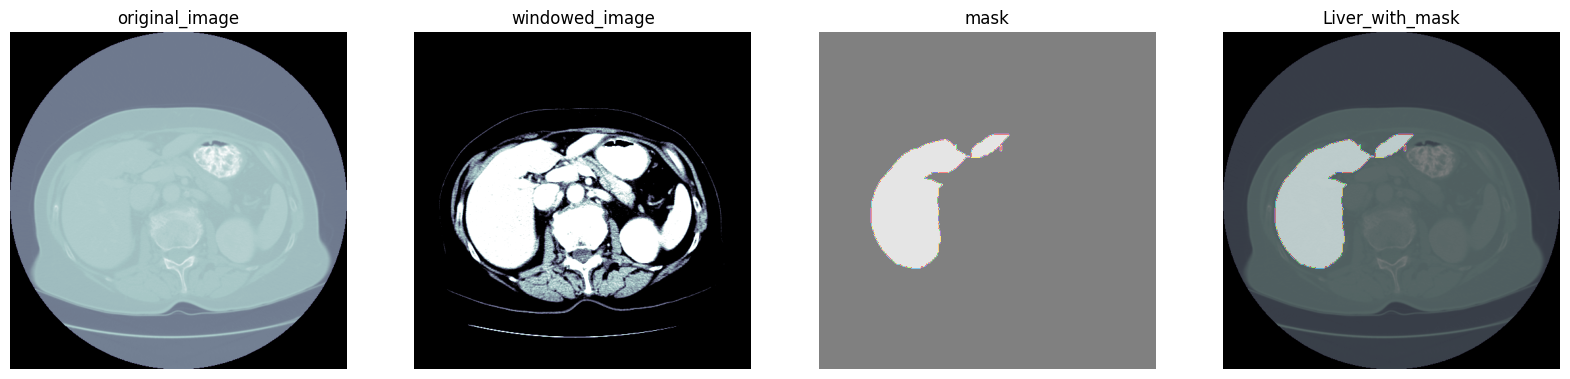

In [ ]:
sample=55
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

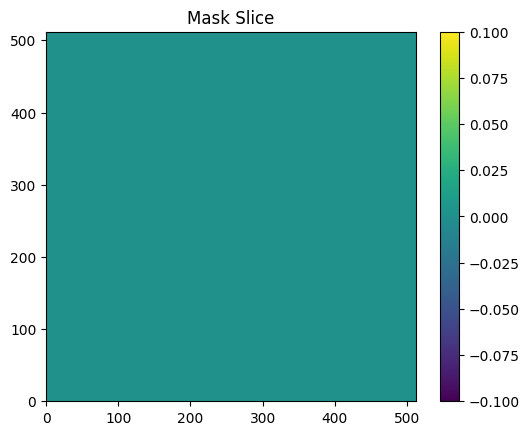

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI mask file
mask_img = nib.load("D:\Liver\Datasets\Segmentation/segmentation-0.nii")
mask_data = mask_img.get_fdata()

# Get a slice of the mask, e.g. the middle slice
slice_num = mask_data.shape[2] // 2
slice_data = mask_data[:, :, slice_num]

# Plot the slice using pcolormesh
plt.figure()
plt.pcolormesh(slice_data)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Mask Slice')
plt.show()

In [ ]:
import nibabel as nib
img = nib.load("D:\Liver\Datasets\Volume/volume-0.nii")
img

In [ ]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  75   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.00000e+00  7.03125e-01  7.03125e-01  5.00000e+00  0.00000e+00
  1.00000e+00  1.00000e+00  5.22410e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b'TE=0;sec=52241.0000;name='
aux_file        : b'!62ABDOMENNATIVUNDVENS'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d    

In [ ]:
img.shape

(512, 512, 75)

In [ ]:
data = img.get_fdata()
data.dtype

dtype('float64')

In [ ]:
data_mean= np.mean(data)
data_std = np.std(data)
print(f"mean : {data_mean},   std : {data_std}")

mean : -948.9269236246745,   std : 1160.8269871267455


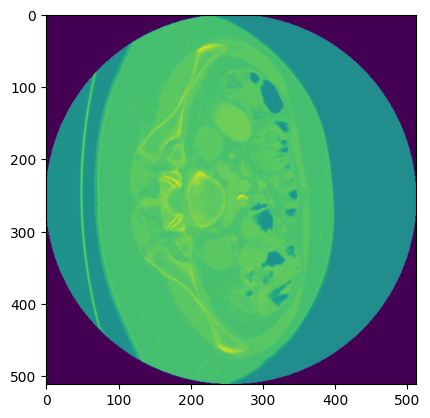

In [ ]:
import matplotlib.pyplot as plt
middle_slice = data[:,:,img.shape[-1]//2 -1]
plt.imshow(middle_slice)

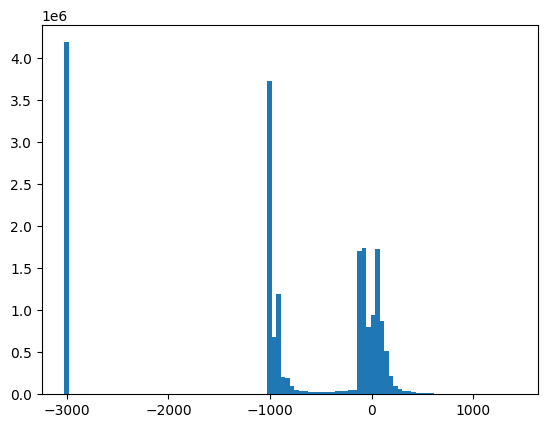

In [ ]:
plt.hist(np.ravel(data), bins=100);

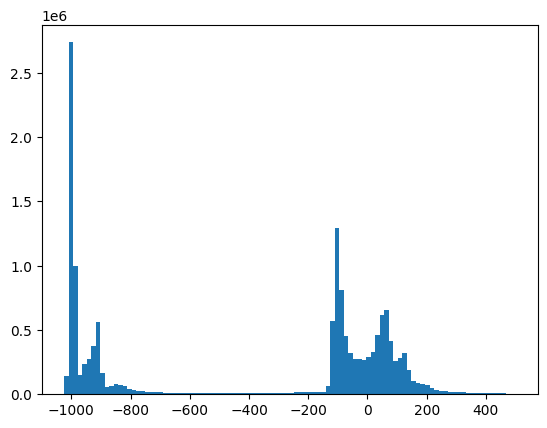

In [ ]:
is_above_0 = data >-1024.2
is_below_1000 = data < 500
# Combine the two selections with & (True if both are True).
is_both = is_above_0 & is_below_1000
plt.hist(data[is_both], bins=100);

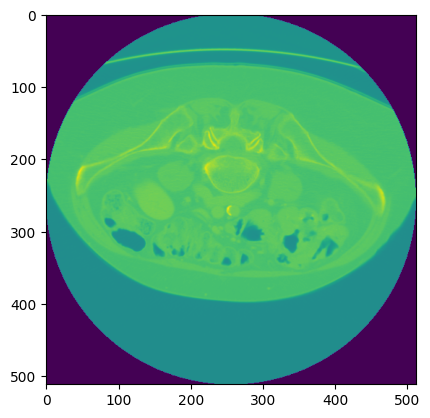

In [ ]:
plt.imshow(middle_slice.T)

In [ ]:
yz_slice = data[img.shape[0]//2-1, :,:]
yz_slice.shape

(512, 75)

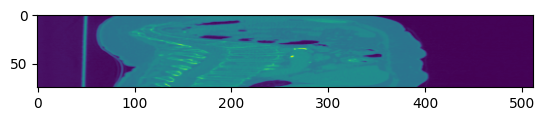

In [ ]:
plt.imshow(yz_slice.T)

In [ ]:
xz_slice = data[:,img.shape[0]//2-1,:]
xz_slice.shape

(512, 75)

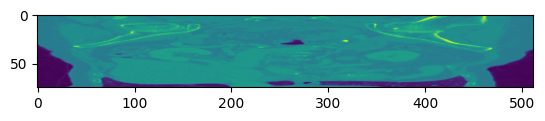

In [ ]:
plt.imshow(xz_slice.T)

<OrthoSlicer3D: D:\Liver\Datasets\Volume/volume-0.nii (512, 512, 75)>

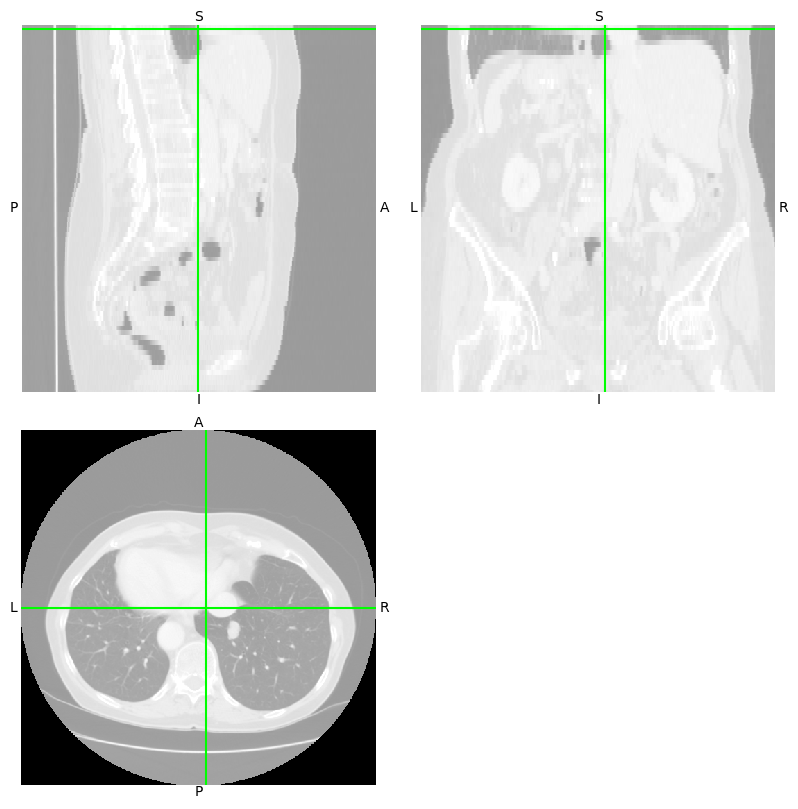

In [ ]:
img.orthoview()